In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [2]:
input = np.load('D:\PersonalFiles\Bristol\GraduationThesis\Code\RNN/input_trial_0_pose_2.npy')
target = np.load('averaged_spike_train.npy')

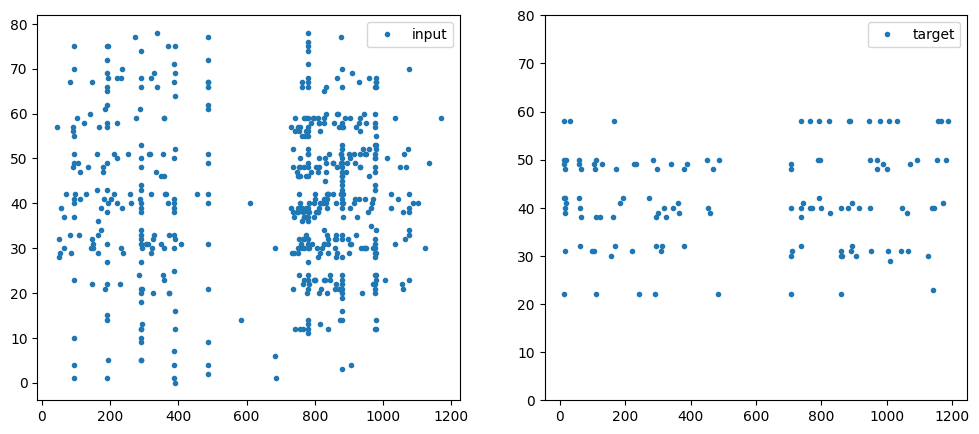

In [3]:
# 输入&目标绘制
plt.figure(figsize=(12,5))

plt.subplot(121)
input_t = []
input_neuron = []
for i, neuron in enumerate(input):
    for t in range(len(neuron)):
        if neuron[t]> 0.5:
            input_neuron.append(i)
            input_t.append(t)
plt.plot(input_t, input_neuron, '.', label='input')
plt.legend()

plt.subplot(122)
target_t = []
target_neuron = []
for i, neuron in enumerate(target):
    for t in range(len(neuron)):
        if neuron[t]> 0.5:
            target_neuron.append(i)
            target_t.append(t)
plt.plot(target_t, target_neuron, '.', label='target')
plt.ylim([0, 80])
plt.legend()

In [4]:
class TouchSim(Dataset):
    def __init__(self):
        super().__init__()
        self.input = input
        self.target = target

        self.input = torch.from_numpy(self.input)
        self.target = torch.from_numpy(self.target)

        self.input = torch.tensor(self.input, dtype=torch.float32)
        self.target = torch.tensor(self.target, dtype=torch.float32)
        # self.target = torch.LongTensor(self.target)

    def __getitem__(self, _):
        return (self.input, self.target)
    
    def __len__(self):
        return 81

train_set = TouchSim()
train_loader = DataLoader(train_set, batch_size=1)

C:\Users\XXC\AppData\Local\Temp\ipykernel_15132\2121072188.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input = torch.tensor(self.input, dtype=torch.float32)
C:\Users\XXC\AppData\Local\Temp\ipykernel_15132\2121072188.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(self.target, dtype=torch.float32)


In [7]:
EPOCH = 10
BATCH_SIZE = 81
TIME_STEP = 1200
INPUT_SIZE = 1
HIDDEN_SIZE = 1

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = torch.nn.GRU(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=2, batch_first=True)
        # self.fc = torch.nn.Linear(16, 2)
    
    def forward(self, x):
        r_out, _ = self.gru(x, None)
        return r_out

device = torch.device('cuda:0')
net = Model().to(device)
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters())

In [22]:
# test
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(inputs.shape, targets.shape)
    print(targets.view(-1, 1).shape)

torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200]) torch.Size([1, 81, 1200])
torch.Size([97200, 1])
torch.Size([1, 81, 1200])

In [16]:
# test
outputs = net(input)
outputs.shape

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [8]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = net(inputs.view(BATCH_SIZE, TIME_STEP, INPUT_SIZE))
        outputs = outputs.reshape(-1, HIDDEN_SIZE)
        print(outputs.shape)
        loss = criterion(outputs, targets.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss))
        running_loss = 0

        if epoch == 2:
            np.save('D:\PersonalFiles\Bristol\GraduationThesis\Code\RNN/outputs.npy', outputs.cpu().detach().numpy())

In [9]:
for epoch in range(EPOCH):
    train(epoch)

torch.Size([97200, 1])


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

In [257]:
outputs = np.load('D:\PersonalFiles\Bristol\GraduationThesis\Code\RNN/outputs.npy')
outputs = outputs.reshape(81, 1200, 2)
outputs.shape

(81, 1200, 2)

In [258]:
outputs

array([[[ 0.41416627, -0.6870819 ],
        [ 0.88601047, -0.90125966],
        [ 0.97102916, -0.94299847],
        ...,
        [ 0.9806133 , -0.9562486 ],
        [ 0.9806133 , -0.9562486 ],
        [ 0.9806133 , -0.9562486 ]],

       [[ 0.41416627, -0.6870819 ],
        [ 0.88601047, -0.90125966],
        [ 0.97102916, -0.94299847],
        ...,
        [ 0.9806133 , -0.9562486 ],
        [ 0.9806133 , -0.9562486 ],
        [ 0.9806133 , -0.9562486 ]],

       [[ 0.41416627, -0.6870819 ],
        [ 0.88601047, -0.90125966],
        [ 0.97102916, -0.94299847],
        ...,
        [ 0.9806133 , -0.9562486 ],
        [ 0.9806133 , -0.9562486 ],
        [ 0.9806133 , -0.9562486 ]],

       ...,

       [[ 0.41416627, -0.6870819 ],
        [ 0.88601047, -0.90125966],
        [ 0.97102916, -0.94299847],
        ...,
        [ 0.9806133 , -0.9562486 ],
        [ 0.9806133 , -0.9562486 ],
        [ 0.9806133 , -0.9562486 ]],

       [[ 0.41416627, -0.6870819 ],
        [ 0.88601047, -0.90

In [241]:
a = outputs.squeeze(0).T
output_t = []
output_neuron = []
for i, neuron in enumerate(a):
    for t in range(len(neuron)):
        if neuron[t]> 0:
            output_neuron.append(i)
            output_t.append(t)
plt.plot(output_t, output_neuron, '.', label='output')
plt.legend()

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [259]:
cnt=0
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        if outputs[i,j,1]>0:
            cnt+=1
cnt

0